# Test Methods

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')


In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            split_name = re.sub(r'([a-z])([A-Z])', r'\1 \2', name)
            split_name = re.sub(r'\d+', '', split_name)  # Remove digits
            return split_name
    return None

def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x.data/1000, y.data/1000

def rotate_20_clockwise(x, y):
    theta = np.deg2rad(20)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

def process_eddy_data(sample_data, eddy, z_r, depth_lvl_limit, method):
    # Initialize empty DataFrames
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    x_diff_df = pd.DataFrame()
    y_diff_df = pd.DataFrame()
    TD_df = pd.DataFrame()
    D_df = pd.DataFrame()

    # Loop over the time data for the given eddy
    for i, time_data in enumerate(sample_data[eddy][method].values()):
        # Process x values
        x = time_data['x'] - time_data.iloc[0]['x']
        if len(x) < depth_lvl_limit:
            nans_to_add = max(0, depth_lvl_limit - len(x))
            x = pd.concat([x, pd.Series([np.nan] * nans_to_add)], ignore_index=True)
        x_df['x'+str(i)] = x
        x_diff_df['x'+str(i)] = x.diff() / np.insert(np.diff(-z_r), 0, np.nan)

        # Process y values
        y = time_data['y'] - time_data.iloc[0]['y']
        if len(y) < depth_lvl_limit:
            nans_to_add = max(0, depth_lvl_limit - len(y))
            y = pd.concat([y, pd.Series([np.nan] * nans_to_add)], ignore_index=True)
        y_df['y'+str(i)] = y
        y_diff_df['y'+str(i)] = y.diff() / np.insert(np.diff(-z_r), 0, np.nan)

        # Calculate total distance (TD) and distance between adjacent points (D)
        TD_df['TD'+str(i)] = np.sqrt(x**2 + y**2)
        D_df['D'+str(i)] = np.sqrt(x.diff()**2 + y.diff()**2) / np.insert(np.diff(-z_r), 0, np.nan)

    # Add mean, std dev, and depth info to the DataFrames
    for df, diff_df, axis_label in [(x_df, x_diff_df, 'x'), (y_df, y_diff_df, 'y'), (TD_df, TD_df, 'TD'), (D_df, D_df, 'D')]:

        mean = df.mean(axis=1)
        std = df.std(axis=1)

        mean_diff = diff_df.mean(axis=1)
        std_diff = diff_df.std(axis=1)

        df['Depth'] = z_r * 1000
        diff_df['Depth'] = z_r * 1000

        df['Mean'] = mean
        df['StdDev'] = std

        diff_df['Mean'] = mean_diff
        diff_df['StdDev'] = std_diff


    return x_df, y_df, x_diff_df, y_diff_df, TD_df, D_df


# Gathering Our Sample

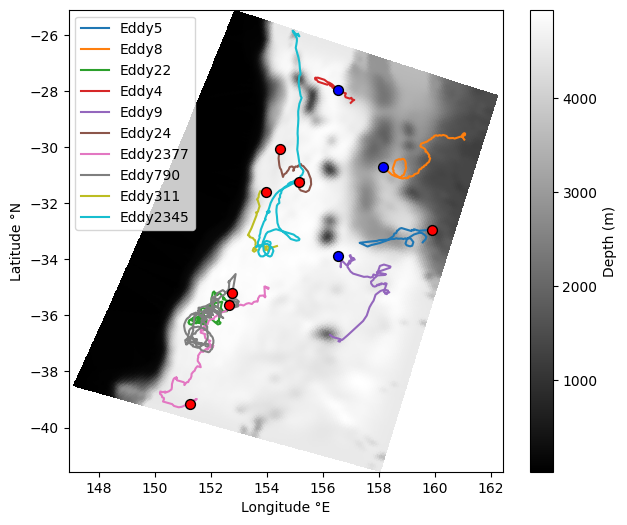

In [4]:
sample_eddies = ['Eddy5', 'Eddy8', 'Eddy22', 'Eddy4', 'Eddy9', 'Eddy24', 'Eddy2377', 'Eddy790', 'Eddy311', 'Eddy2345']

colors = plt.get_cmap('tab10')

plt.figure(figsize=(7, 6))

plt.pcolormesh(lon_rho, lat_rho, h, shading='auto', cmap='gray')
plt.colorbar(label='Depth (m)')
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')

for i, e in enumerate(sample_eddies):
    eddy_data = eddies[e]
    
    plt.plot(eddy_data['Lon'], eddy_data['Lat'], color=colors(i), label=e)
    
    plt.scatter(eddy_data['Lon'].iloc[-1], eddy_data['Lat'].iloc[-1], color='r' if eddy_data['Vort'].iloc[-1] > 0 else 'b', edgecolor='black', s=50, zorder=5)

# plt.xlim([148, 161])
plt.axis('equal')

plt.legend(loc='upper left')
plt.show()


In [5]:
with open('/srv/scratch/z5297792/Sample/sample_data_CE9.pkl', 'rb') as file:
    sample_data = pickle.load(file)

In [6]:
sample_data.keys()

dict_keys(['Eddy9'])

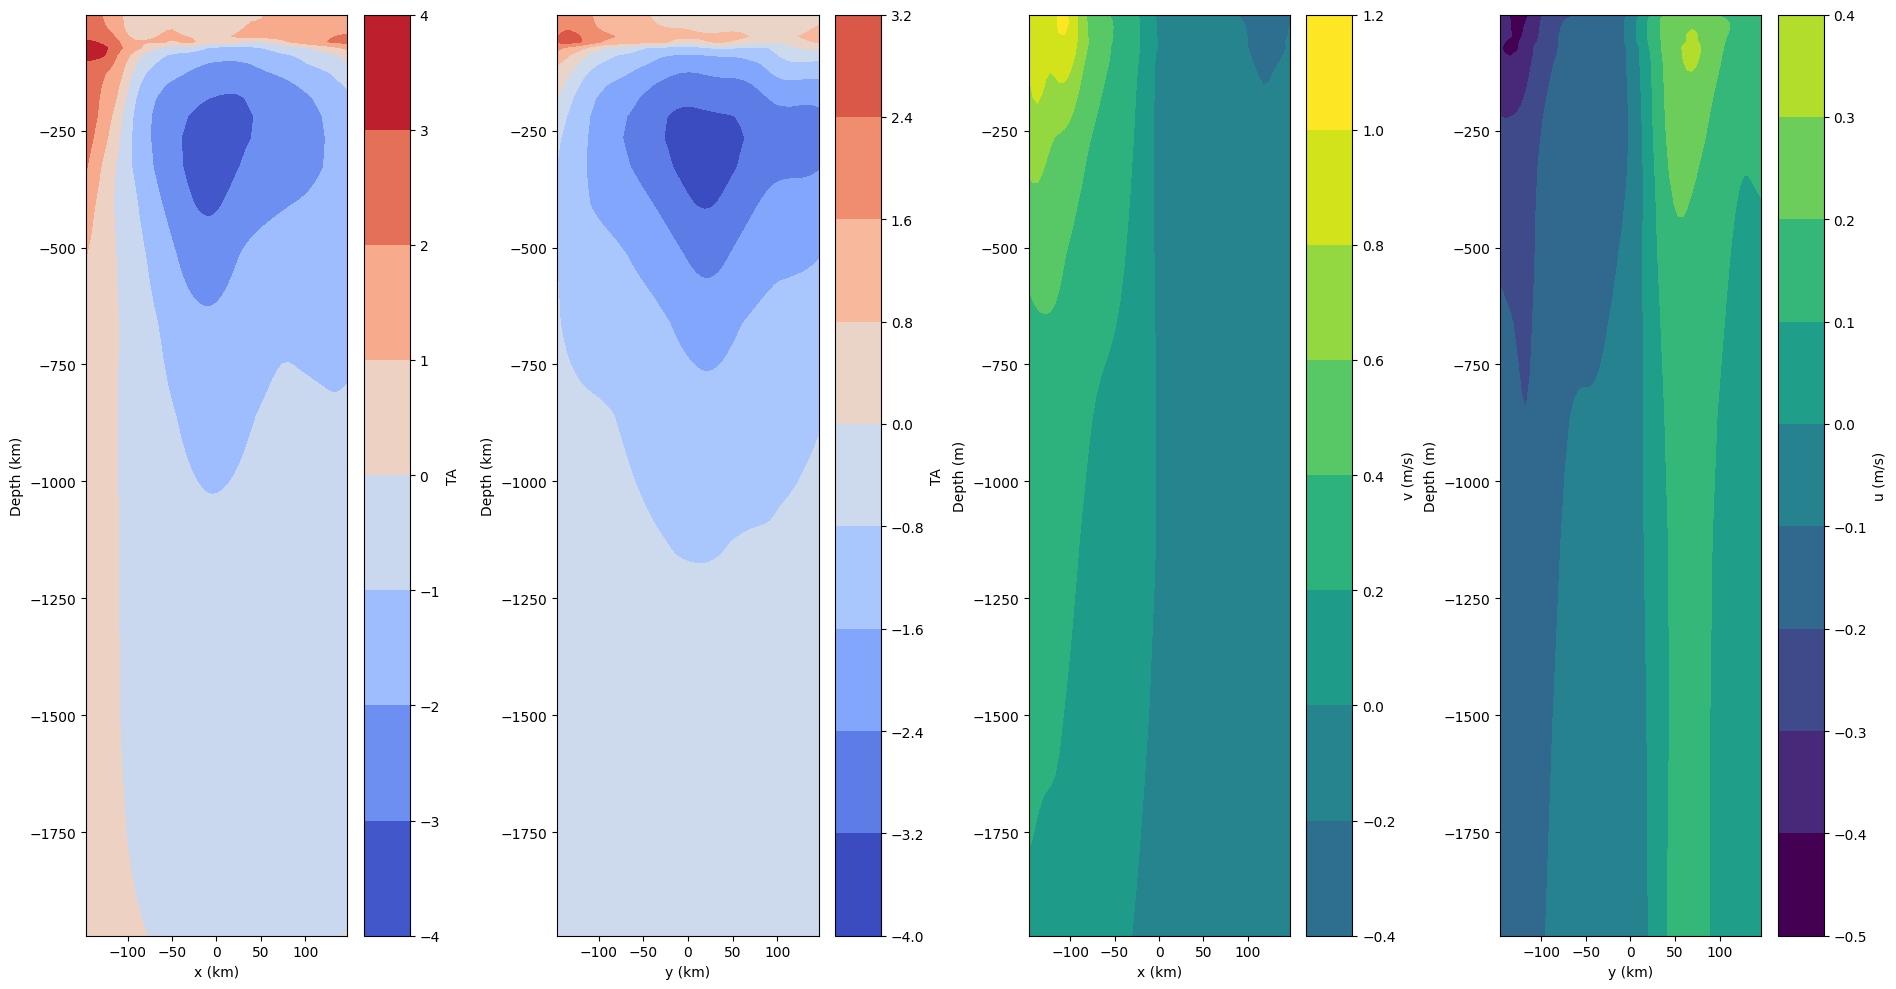

In [7]:
import matplotlib.colors as mcolors

DISPLAY_WIDTH = 300000
DEPTH_LVL_LIMIT = 25

eddy = 'Eddy9'

U = sample_data[eddy]['U']
V = sample_data[eddy]['V']
TA = sample_data[eddy]['TA']

t = TA.shape[-1] // 2

t0 = eddies[eddy].shape[0] // 2 - 15

t_eddy_relative = t + t0

DataField = TA

DataField_name = get_variable_name(DataField)
DataField = np.squeeze(DataField[:, :, :, t])
DataField = np.where(abs(DataField) > 1e30, np.nan, DataField)

i_search, j_search = eddies_nearest_rho(eddies[eddy].iloc[t_eddy_relative].Lon, eddies[eddy].iloc[t_eddy_relative].Lat)

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

fig, axs = plt.subplots(1, 4, figsize=(19, 10))

# First subplot
DataField_cross = DataField[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
X, Z = np.meshgrid(x, z_r[150, 150, :DEPTH_LVL_LIMIT])
DataField_data_range = np.nanmax(np.abs(DataField_cross))
c1 = axs[0].contourf(X, Z, DataField_cross.T, cmap='coolwarm', vmin=-DataField_data_range, vmax=DataField_data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
fig.colorbar(c1, ax=axs[0], label=DataField_name)

# Second subplot
DataField_cross = DataField[i_search, j_down:j_up, :DEPTH_LVL_LIMIT] 
Y, Z = np.meshgrid(y, z_r[150, 150, :DEPTH_LVL_LIMIT])
DataField_data_range = np.nanmax(np.abs(DataField_cross))
c2 = axs[1].contourf(Y, Z, DataField_cross.T, cmap='coolwarm', vmin=-DataField_data_range, vmax=DataField_data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (km)')
fig.colorbar(c2, ax=axs[1], label=DataField_name)

# Second subplot
v_cross = V[i_left:i_right, j_search, :DEPTH_LVL_LIMIT, t]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x, z_r[150, 150, :DEPTH_LVL_LIMIT])
c1 = axs[2].contourf(X, Z, v_cross.T, cmap='viridis', vmin=-v_data_range, vmax=v_data_range)
axs[2].set_xlabel('x (km)')
axs[2].set_ylabel('Depth (m)')
fig.colorbar(c1, ax=axs[2], label='v (m/s)')

# Third subplot
u_cross = U[i_search, j_down:j_up, :DEPTH_LVL_LIMIT, t]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y, z_r[150, 150, :DEPTH_LVL_LIMIT])
c2 = axs[3].contourf(Y, Z, u_cross.T, cmap='viridis', vmin=-u_data_range, vmax=u_data_range)
axs[3].set_xlabel('y (km)')
axs[3].set_ylabel('Depth (m)')
fig.colorbar(c2, ax=axs[3], label='u (m/s)')

plt.tight_layout()
plt.show()

# SSIM

In [8]:
with open('/srv/scratch/z5297792/Sample/sample_data_CE9.pkl', 'rb') as file:
    sample_data = pickle.load(file)

In [9]:
eddy = 'Eddy9'
sample_data['Eddy9'].keys()

dict_keys(['U', 'V', 'TA', 'CS', 'OW'])

In [10]:
from skimage.metrics import structural_similarity as ssim

def correlation_center_finder(grid1, grid2):
    def cycle_matrix(matrix, row_shift, col_shift):
        row_shift %= matrix.shape[0]
        col_shift %= matrix.shape[1]
        return np.roll(np.roll(matrix, row_shift, axis=0), col_shift, axis=1)
    def compare_matrices_ssim(matrix1, matrix2):
        data_range = max(Data_abv.max(), Data_blw.max()) - min(Data_abv.min(), Data_blw.min())
        return np.abs(ssim(matrix1, matrix2, data_range=data_range)) # Have |SSIM| it 
    def center_list(n):
        midpoint = n // 2
        return np.arange(-midpoint, n - midpoint)
    xs = center_list(grid1.shape[1])
    ys = center_list(grid1.shape[0])
    correlations = [
        (x, y, compare_matrices_ssim(grid1, cycle_matrix(grid2, y, x)))
        for x in xs for y in ys
    ]
    df = pd.DataFrame(correlations, columns=['Right', 'Up', 'SSI'])

    best_shift = df.loc[df['SSI'].idxmax()]

    def make_ssi_matrix(df):
        xs, ys, values = df.Right, df.Up, df.SSI
        ssim_mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
        for i in np.unique(xs):
            for j in np.unique(ys):
                ssim_mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'SSI'].values[0]
        return ssim_mat
    ssi_mat = make_ssi_matrix(df)

    return df, ssi_mat, best_shift['Up'], best_shift['Right']

from scipy.interpolate import griddata
def interpolate_to_dx_spacing_SSIM(x, y, Z, dx, noise):

    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    # Round x_min, x_max, y_min, and y_max to the nearest multiple of dx
    x_min = round(x_min / dx) * dx
    x_max = round(x_max / dx) * dx
    y_min = round(y_min / dx) * dx
    y_max = round(y_max / dx) * dx

    xy_abs = min(abs(x_min), abs(x_max), abs(y_min), abs(y_max))
        
    # Generate new grid points with spacing dx
    x_new = np.arange(-xy_abs, xy_abs + dx, dx)
    y_new = np.arange(-xy_abs, xy_abs + dx, dx)

    original_points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    
    values = Z.flatten()
    new_points = np.array(np.meshgrid(x_new, y_new)).T.reshape(-1, 2)
    
    Z_new = griddata(original_points, values, new_points, method='linear')

    Z_new = Z_new.reshape(len(y_new), len(x_new))

    # Fill NaNs with noise (Tried it and it failed!)
    # uniform_noise = np.random.uniform(-1e6, 1e6, size=Z_new.shape)
    uniform_noise = np.ones(Z_new.shape) * noise
    Z_new = np.where(np.isnan(Z_new), uniform_noise, Z_new)
        
    return x_new, y_new, Z_new

In [11]:
sample_data[eddy]['SSIM'] = {}

In [ ]:
for t in range(sample_data[eddy]['U'].shape[-1]):

    DataField = sample_data[eddy]['TA'][:,:,:,t]

    from scipy.interpolate import griddata
    
    SEARCH_WIDTH = 200000
    DEPTH_LVL_LIMIT = 23
    
    ics, jcs = [], []
    depth_dics4 = {}
    t0 = eddies[eddy].shape[0] // 2 - 15
    t_eddy_relative = t + t0
    edata = eddies[eddy].iloc[t_eddy_relative]
    i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
    clon, clat = edata.Lon, edata.Lat # Center of grid doesnt move
    xc, yc = 0, 0
    for depth_lvl in range(DEPTH_LVL_LIMIT):
        i_search_lvl, j_search_lvl = eddies_nearest_rho(clon, clat)
        i_left, i_right, j_down, j_up = grid_finder(i_search_lvl, j_search_lvl, SEARCH_WIDTH)
    
        x, y = eddy_centric_grid_distances(i_search_lvl, j_search_lvl, i_left, i_right, j_down, j_up)
    
        x *= 1000
        y *= 1000
    
        Data_abv = DataField[i_left:i_right, j_down:j_up, depth_lvl]
        Data_blw = DataField[i_left:i_right, j_down:j_up, depth_lvl + 1]
    
        dx = SEARCH_WIDTH // 100
        _, _, Data_abv = interpolate_to_dx_spacing_SSIM(x, y, Data_abv, dx, noise=1e6)
        x, y, Data_blw = interpolate_to_dx_spacing_SSIM(x, y, Data_blw, dx, noise=-1e6)
    
        df, ssi_mat, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    
        xc += dx * iU
        yc += dx * iR
    
        depth_dics4[f'Depth{depth_lvl}'] = {
            'SSI_Mat': ssi_mat, 
            'xc': xc, 
            'yc': yc, 
            'Max SSI': float(np.nanmax(df.SSI)),
            'Depth': float(z_r[150, 150, depth_lvl])
        }
        
        xcs, ycs, zcs = [], [], []
        for depth_dic in depth_dics4.values():
            xcs.append(depth_dic['xc']/1000)
            ycs.append(depth_dic['yc']/1000)
            zcs.append(depth_dic['Depth'])
        
        sample_data[eddy]['SSIM']['T'+str(t)] = pd.DataFrame({
            'x': xcs,
            'y': ycs,
            'Depth': zcs
        })
    print(t)

0
1
2
3
4
5
6
7
8
9
10


Takes about 3min per day

In [ ]:
DISPLAY_WIDTH = 200000

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)
xcs, ycs, zcs = [], [] ,[]
for depth_dic in depth_dics4.values():
    xcs.append(depth_dic['xc']/1000)
    ycs.append(depth_dic['yc']/1000)
    zcs.append(depth_dic['Depth'])

xcs, ycs = rotate_20_clockwise(xcs, ycs)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
DataField2_cross = DataField[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
X, Z = np.meshgrid(x, z_r[150, 150, :DEPTH_LVL_LIMIT])
DataField2_data_range = np.nanmax(np.abs(DataField2_cross))
c1 = axs[0].contourf(X, Z, DataField2_cross.T, cmap='coolwarm', vmin=-DataField2_data_range, vmax=DataField2_data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
axs[0].set_title('SSIM Method Results along x-axis')
fig.colorbar(c1, ax=axs[0])
# axs[0].scatter(xcs, zcs, color='k', s=10, marker='s')
axs[0].plot(xcs, zcs, color='k', linewidth=2)

# Second subplot
DataField2_cross = DataField[i_search, j_down:j_up, :DEPTH_LVL_LIMIT] 
Y, Z = np.meshgrid(y, z_r[150, 150, :DEPTH_LVL_LIMIT])
DataField2_data_range = np.nanmax(np.abs(DataField2_cross))
c2 = axs[1].contourf(Y, Z, DataField2_cross.T, cmap='coolwarm', vmin=-DataField2_data_range, vmax=DataField2_data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (km)')
axs[1].set_title('SSIM Method Results along y-axis')
fig.colorbar(c2, ax=axs[1])
# axs[1].scatter(ycs, zcs, color='k', s=10, marker='s')
axs[1].plot(ycs, zcs, color='k', linewidth=2)
axs[1].legend(['SSIM'])

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for time_data in sample_data[eddy]['SSIM'].values():

    axs[0].plot(time_data['x'] - time_data.iloc[0]['x'], time_data['Depth'])

    axs[1].plot(time_data['y'] - time_data.iloc[0]['y'], time_data['Depth'])

axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()

In [ ]:
SSIM_x_df, SSIM_y_df, SSIM_x_diff_df, SSIM_y_diff_df, SSIM_TD_df, SSIM_D_df = process_eddy_data(sample_data, eddy, z_r[150, 150, :DEPTH_LVL_LIMIT]/1000, DEPTH_LVL_LIMIT, 'SSIM')

max_x_value = max(
    np.nanmax(abs(SSIM_x_diff_df['Mean'] + SSIM_x_diff_df['StdDev'])),
    np.nanmax(abs(SSIM_y_diff_df['Mean'] + SSIM_y_diff_df['StdDev'])),
    np.nanmax(abs(SSIM_D_df['Mean'] + SSIM_D_df['StdDev']))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot for Delta x / Depth
axs[0].plot(SSIM_x_diff_df['Mean'], SSIM_x_diff_df['Depth'], linewidth=2)
axs[0].fill_betweenx(SSIM_x_diff_df['Depth'], SSIM_x_diff_df['Mean'] - SSIM_x_diff_df['StdDev'], SSIM_x_diff_df['Mean'] + SSIM_x_diff_df['StdDev'], color='r', alpha=0.3)
axs[0].set_xlabel(r'$\frac{\Delta x}{ \Delta \text{Depth}}$')
axs[0].set_ylabel('Depth (m)')
axs[0].axvline(x=0, color='k', linewidth=0.5)
axs[0].set_xlim([-max_x_value, max_x_value])

# Plot for Delta y / Depth
axs[1].plot(SSIM_y_diff_df['Mean'], SSIM_y_diff_df['Depth'], linewidth=2)
axs[1].fill_betweenx(SSIM_y_diff_df['Depth'], SSIM_y_diff_df['Mean'] - SSIM_y_diff_df['StdDev'], SSIM_y_diff_df['Mean'] + SSIM_y_diff_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel(r'$\frac{\Delta y}{ \Delta \text{Depth}}$')
axs[1].set_ylabel('Depth (m)')
axs[1].axvline(x=0, color='k', linewidth=0.5)
axs[1].set_xlim([-max_x_value, max_x_value])

# Plot for Delta Horizontal Distance / Depth
axs[2].plot(SSIM_D_df['Mean'], SSIM_D_df['Depth'], linewidth=2)
axs[2].fill_betweenx(SSIM_D_df['Depth'], SSIM_D_df['Mean'] - SSIM_D_df['StdDev'], SSIM_D_df['Mean'] + SSIM_D_df['StdDev'], color='r', alpha=0.3)
axs[2].set_xlabel(r'$\frac{\Delta \text{Horiz. Dist.}}{ \Delta \text{Depth}}$')
axs[2].set_ylabel('Depth (m)')
axs[2].axvline(x=0, color='k', linewidth=0.5)
axs[2].set_xlim([0, max_x_value])

# Plot title and layout
plt.suptitle('SSIM')
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for key in SSIM_TD_df.keys():
    if key not in ['Depth', 'Mean', 'StdDev']:
        axs[0].plot(SSIM_TD_df[key], z_r[150, 150, :DEPTH_LVL_LIMIT])
axs[0].set_xlabel('TD (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(SSIM_TD_df['Mean'], SSIM_TD_df['Depth'])
axs[1].fill_betweenx(SSIM_TD_df['Depth'], SSIM_TD_df['Mean'] - SSIM_TD_df['StdDev'], SSIM_TD_df['Mean'] + SSIM_TD_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth (m)')

plt.suptitle('SSIM')
plt.tight_layout()
plt.show()


In [ ]:
with open('/srv/scratch/z5297792/Sample/sample_data_CE9.pkl', 'wb') as file:
    pickle.dump(sample_data, file)